A simple notebook for testing a SR model.

# Setup

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [2]:
from facedataset import FaceDataset
from metrics import psnr
from loss_functions import PerceptionLoss, VGGPerceptionLoss, DiscriminatorLoss, MixLoss

In [3]:
from model import Model
from discriminator import Discriminator

In [4]:
from train_functions import train_model, train_mix, train_discriminator

In [5]:
import PIL
from classic_model import Classic

Make torch as determenistic as possible:

In [6]:
def reset_seeds():
    random.seed(714)
    np.random.seed(714)
    torch.manual_seed(714)

reset_seeds()
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Hyperparameters:

In [7]:
batch_size = 64 # must be divisble by 2
input_size = 32
upscaling_factor = 2
output_size = upscaling_factor*input_size
use_gpu = torch.cuda.is_available()

num_examples = 10 # number of examples printed
data_path = "data/small256x256"

In [8]:
train_set = FaceDataset(data_path, 0, 55000, input_size, upscaling_factor)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True, drop_last=True, num_workers=4)

In [9]:
val_set = FaceDataset(data_path, 55000, 65000, input_size, upscaling_factor)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle=True, num_workers=4)

Ignore test set (65 000 -- 70 000) for now

## Example Batch


In [ ]:
fig, ax = plt.subplots(num_examples, 2)
lower, higher = next(iter(train_loader))
for i in range(num_examples):
    ax[i][0].imshow(lower[i].detach().permute(1,2,0))
    ax[i][1].imshow(higher[i].detach().permute(1,2,0))
    ax[i][0].axis('off')
    ax[i][1].axis('off')
fig.set_size_inches(6, 3*num_examples)
plt.tight_layout()
plt.show()

# Training

## Definitions

In [ ]:
def save_model(model, name):
    torch.save(model.state_dict(), f'weights/{name}.ckpt')

In [ ]:
def load_model(name):
    model = Model()
    model.load_state_dict(torch.load(f"weights/{name}.ckpt", map_location=torch.device('cpu')))
    if use_gpu:
        model = model.cuda()
    
    return model

In [ ]:
def get_val_psnr(model):
    model.eval()

    with torch.no_grad():
        val_psnr = []

        for img, target in tqdm(val_loader):
            if use_gpu:
                img = img.cuda()
                target = target.cuda()
            out = model(img)
            val_psnr.append(psnr(out, target))


        val_psnr = torch.cat(val_psnr)
        return val_psnr


## Initialization

In [10]:
reset_seeds()

In [10]:
model = Model(upscaling_factor)
if use_gpu:
    model = model.cuda()

In [11]:
discriminator = Discriminator(output_size)
if use_gpu:
    discriminator = discriminator.cuda()

In [15]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

114796

In [16]:
sum(p.numel() for p in discriminator.parameters() if p.requires_grad)

177657

## Trainings programm

In [19]:
train_loader.batch_size

64

In [14]:
opt_model = torch.optim.Adam(model.parameters(), 1e-4)
opt_disc = torch.optim.Adam(discriminator.parameters(), 1e-4)
train_mix(model, discriminator, nn.MSELoss(), opt_model, opt_disc, train_loader, use_gpu=use_gpu)

KeyboardInterrupt: 

In [13]:
?train_mix

In [16]:
opt_model = torch.optim.Adam(model.parameters(), 1e-4)
crit = VGGPerceptionLoss()
psnrs = []
for ep in tqdm(range(100)):
    train_model(model, crit, opt_model, train_loader, use_gpu=use_gpu)
    
    vals = get_val_psnr(model)
    psnrs.append([torch.mean(vals), torch.std(vals)])
    print(f"Mean PSNR {psnrs[-1][0]:.2f} ± {psnrs[-1][1]:.2f}")

KeyboardInterrupt: 

In [ ]:
arr = np.array(psnrs)
plt.plot(arr[:,0])
plt.show()

# Evaluation

In [ ]:
from skimage.metrics import structural_similarity as ssim

model.eval()

with torch.no_grad():
    val_psnr = []
    val_ssim = []

    for img, target in tqdm(val_loader):
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        out = model(img)
        val_psnr.append(psnr(out, target))
        out = out.cpu().permute(0, 2, 3, 1).numpy()
        target = target.cpu().permute(0, 2, 3, 1).numpy()
        for i in range(out.shape[0]):
            val_ssim.append(ssim(out[i], target[i], data_range=1, multichannel=True))


    val_psnr = torch.cat(val_psnr)
    val_ssim = torch.tensor(val_ssim)

print(f"Mean PSNR {torch.mean(val_psnr):.2f} ± {torch.std(val_psnr):.2f}")
print(f"Mean SSIM {torch.mean(val_ssim):.3f} ± {torch.std(val_ssim):.2f}")

In [ ]:
val_psnr = get_val_psnr(model)
print(f"Mean PSNR {torch.mean(val_psnr):.2f} ± {torch.std(val_psnr):.2f}")

In [ ]:
discriminator.eval()
model.eval()

with torch.no_grad():
    acc_upsc = []
    acc_orig = []
    
    for img, target in tqdm(val_loader):
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        out = model(img)
        pred_upsc = discriminator(out)
        acc_upsc.append(pred_upsc > 0.5)
        pred_orig = discriminator(target)
        acc_orig.append(pred_orig <= 0.5)
    
    acc_upsc = torch.cat(acc_upsc).float()
    acc_orig = torch.cat(acc_orig).float()
    
    print(f"Acc: {0.5*(torch.mean(acc_upsc) + torch.mean(acc_orig))}",
        f"Upscaled: {torch.mean(acc_upsc)}",
        f"Original: {torch.mean(acc_orig)}", sep="\t")

Upscaling side to side with input and original:

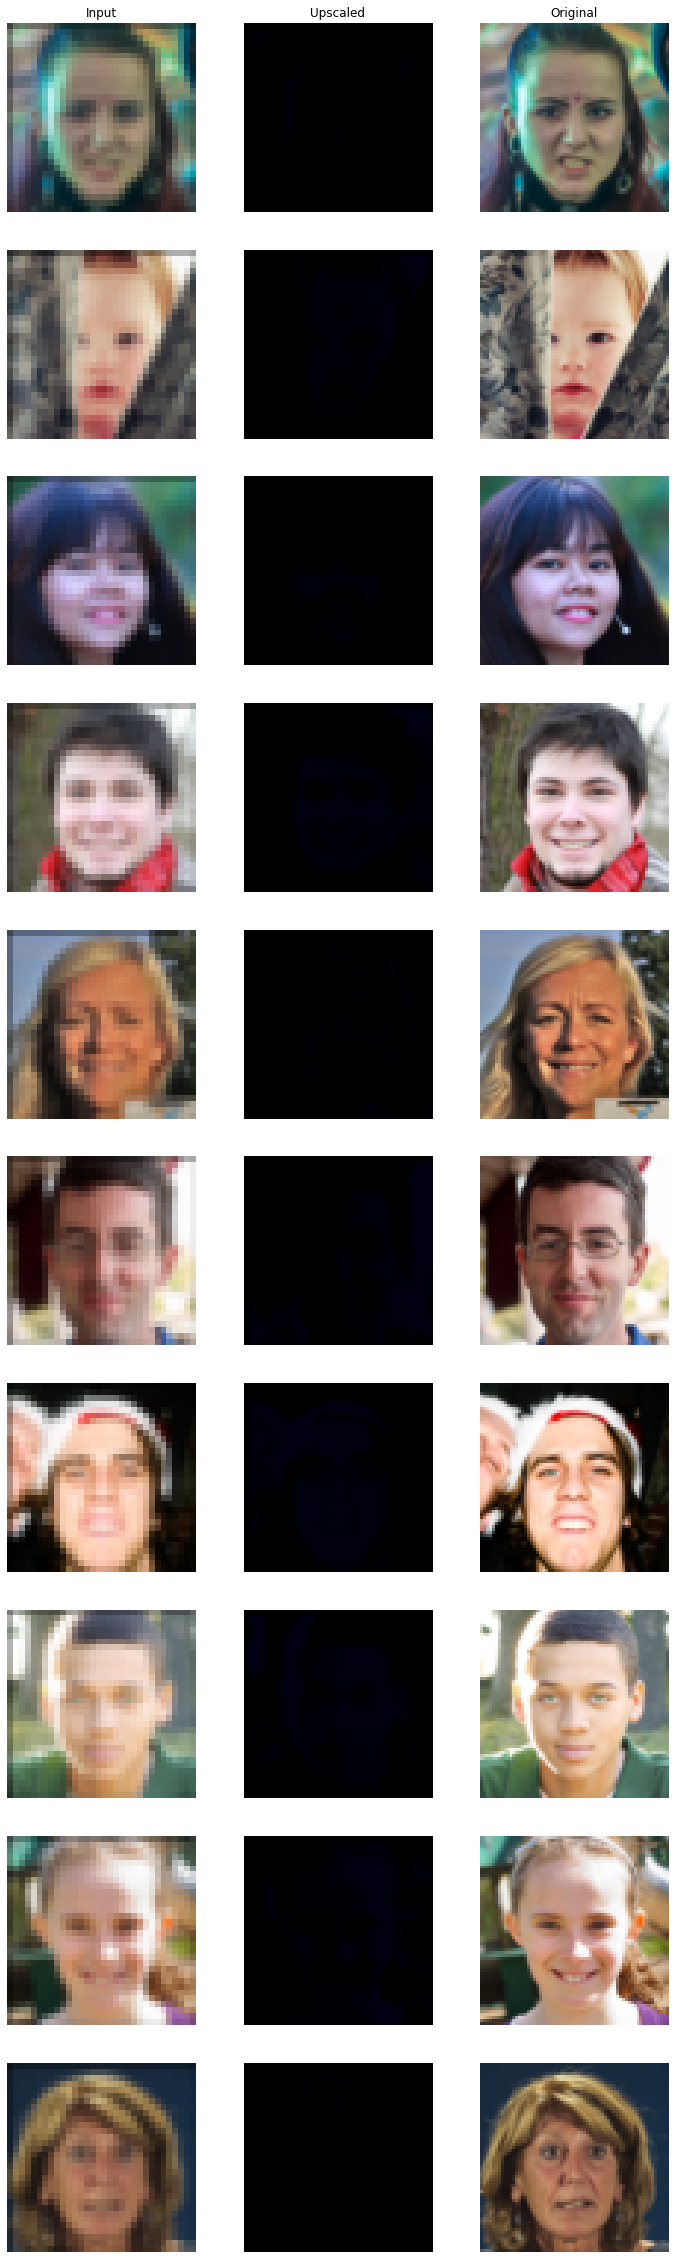

In [19]:
model.eval()

with torch.no_grad():
    it = iter(val_loader)
    img, target = next(it)
    if use_gpu:
        img, target = img.cuda(), target.cuda()
    out = torch.clamp(model(img), 0, 1).cpu()
    img, target = img.cpu(), target.cpu()
    
    fig, ax = plt.subplots(num_examples, 3)
    for i in range(num_examples):
        ax[i][0].imshow(img[i].permute(1,2,0))
        ax[i][1].imshow(out[i].permute(1,2,0))
        ax[i][2].imshow(target[i].permute(1,2,0))
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        ax[i][2].axis('off')
    fig.set_size_inches(12, 4*num_examples+1)
    
    ax[0][0].set_title("Input")
    ax[0][1].set_title("Upscaled")
    ax[0][2].set_title("Original")

    plt.show()

Multiple upscalings in succession:

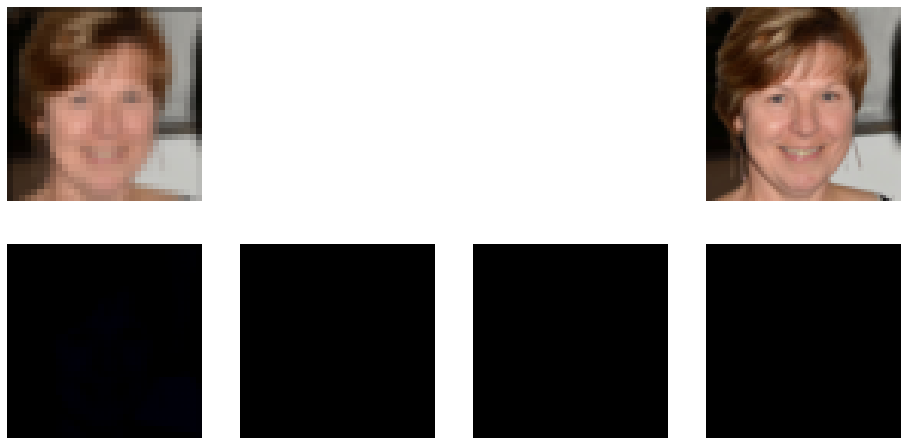

In [20]:
model.eval()

with torch.no_grad():
    steps = 4
    fig, ax = plt.subplots(2, steps)
    img, target = next(iter(val_loader))
    img, target = img[0], target[0]
    ax[0][0].imshow(img.permute(1,2,0))
    ax[0][-1].imshow(target.permute(1,2,0))
    ax[0][0].axis('off')
    ax[0][-1].axis('off')
    for i in range(1,steps-1):
        fig.delaxes(ax[0][i])
    
    if use_gpu:
        img, target = img.cuda(), target.cuda()
    out = img.unsqueeze(0)
    for k in range(steps):
        out = torch.clamp(model(out), 0, 1)
        ax[1][k].imshow(out[0].permute(1,2,0).cpu())
        ax[1][k].axis('off')
    
    fig.set_size_inches(4*steps, 8)
    plt.show()